# Imports

In [256]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from PIL import Image 
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import shutil
import torchvision


In [257]:
# set the necessary directories
root_dir = os.getcwd() 
img_dir = root_dir+'/inputs/Images/'

img_filenames = os.listdir(img_dir)
img_names = [s.split('.')[0] for s in img_filenames]

img_ext = '.jpg'

# Defining Masks

Masks are encoded in SIGRID-3 format. See here for more information: https://library.wmo.int/doc_num.php?explnum_id=9270

We will map the ice concentratoin codes according to the following library to simplify the classes

In [258]:
mask_lib = {55:0, #ice free
            1:0, #<1/10 (open water)
            2:0, #bergy water
            10:1, #1/10
            12:1, #1/10-2/10
            13:1, #1/10-3/10
            20:1, #2/20
            23:1, #2/20-3/10
            24:2, #2/20-4/10
            30:2, #...
            34:2,
            35:2,
            40:2,
            45:2,
            46:3,
            50:3,
            56:3,
            57:3,
            60:3,
            67:3,
            68:4, #...
            70:4, #7/10
            78:4, #7/10-8/10
            79:4, #7/10-9/10
            80:4, #8/10
            89:4, #8/10-9/10
            81:5, #8/10-10/10
            90:5, #9/10
            91:5, #9/10-10/10
            92:6, #10/10 - fast ice
            100:7, #land
            99:7, #unknown - there is nothing in this class for this dataset
           }

#define a colormap for the mask
n_colors=8
ice_colors = n_colors-1
jet = plt.get_cmap('jet', ice_colors)
newcolors = jet(np.linspace(0, 1, ice_colors))
black = np.array([[0, 0, 0, 1]])
white = np.array([[1, 1, 1, 1]])
newcolors = np.concatenate((newcolors, black), axis=0) #land will be black
cmap = ListedColormap(newcolors)

Run through and convert all masks from SIGRID-3 to simplified. Also store the pixel class counts for each mask in a dataframe.

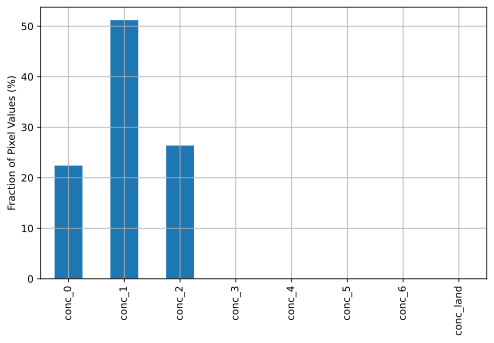

In [259]:
#function to map mask values according to above library
def map_mask(mask, lib):
    new_mask = mask.copy()
    for key, val in lib.items():#map the elements of the array to their new values according to the library
        new_mask[mask==key]=val
    return new_mask

#function to calculate the value counts over all pixels in an image (fed in as a numpy array)
def bincount_2d(arr, max_int):
    counts_full = [0 for n in range(max_int)]
    for row in arr:
        counts = np.bincount(row).tolist()#get the counts for the row
        pad = [0 for n in range(max_int-len(counts))]
        counts = counts + pad #add extra zeroes to account for colors above the max in the row
        counts_full = [counts_full[n] + counts[n] for n in range(max_int)]
    return(counts_full)

# convert all mask files from SIGRID 3 format to simplified
mask_dir = root_dir +'/inputs/Masks/'
mask_ext = '-mask.png'
new_mask_ext = '-mask-mod.png'
new_mask_dir = root_dir +'/new_mask/'#update mask directory and extension
if os.path.exists(new_mask_dir):
    shutil.rmtree(new_mask_dir)
os.makedirs(new_mask_dir)
dat = []#list that will hold information on the masks

for img_name in img_names:
    name = mask_dir + img_name
    # importing the image  
    mask = Image.open(name + mask_ext)

    # converting mask
    mask = np.array(mask)#convert to numpy
    # new_mask = map_mask(mask, mask_lib)#map values
    new_mask = mask.copy()
    #update dataframe
    name = img_name.split('-')  
    d = [img_name, 
         name[0][1:],  #patch id
         name[1][0:4], #year
         name[1][4:6], #month
         name[1][6:8], #day
         name[1][8:10]]#hour
    
    counts = bincount_2d(new_mask, n_colors) #values counts of the class of ice over all pixels in the image
    d.extend(counts)
    dat.append(d)
    
    # exporting the image 
    new_mask_img = Image.fromarray(np.uint8(new_mask))#convert back to image
    new_mask_img.save(new_mask_dir + img_name + new_mask_ext, 'PNG') 

mask_dir = new_mask_dir
mask_ext = new_mask_ext

#create dataframe of mask information
mask_df = pd.DataFrame(dat, columns = ['name', 'patch_id', 'year', 'month', 'day', 'hour', 
                            'conc_0', 'conc_1', 'conc_2', 'conc_3', 'conc_4', 'conc_5', 'conc_6',  
                            'conc_land'])

#plot realtive frequency of ice concentrations in images
counts = mask_df.iloc[:,6:].sum()
norm = counts.sum()
probs = counts/norm*100

plt.figure(figsize=(8,5))
probs.plot(kind='bar')
plt.ylabel('Fraction of Pixel Values (%)')
plt.grid()

In [260]:
# mask = Image.open(mask_dir + 'P1-2018061817' + mask_ext)
# type(mask)
# # image_gray = mask.convert('L')
# # image_gray.show()
# mask_a = np.asarray(mask)#convert to numpy
# mask_b = Image.fromarray(np.uint8(mask_a))

# new_mask = map_mask(mask_a, mask_lib)#map values
# # print(new_mask)
# # new_mask = mask_a.copy()
# # print(new_mask)
# new_mask_img = Image.fromarray(np.uint8(new_mask*155))
# new_mask_img



We see that classes for 0%, 90%, and 100% ice concentration and the land class make up most of the pixels. To deal with this class imbalance in our model, we will over-sample images that contain more than 30% of the minority classes.

In [261]:
mask_df['conc_minor']=mask_df[['conc_1', #lists the total concentration of under-represented ice classes
                               'conc_2', 
                               'conc_3', 
                               'conc_4', 
                              ]].sum(axis=1)

n_pixels = mask_df.iloc[0, 6:].sum(axis=0)#total number of pixels in each image
over_sample_names = mask_df[mask_df['conc_minor']/n_pixels>0.3] #we will over-sample these images of the under-represented classes
over_sample_names = over_sample_names['name'].values.tolist()

# PyTorch Input Pipeline

In [262]:
class_max = mask_df.iloc[:,6:-1].idxmax(axis=1) #category of the most common class in the image. We will stratify our train test split by this
class_max.value_counts()

conc_0    2580
conc_1     510
conc_2     302
dtype: int64

In [263]:
from sklearn.model_selection import train_test_split
# pick which images we will use for testing and which for validation
names = mask_df['name'].values
train_names, validation_names, train_max, validation_max = train_test_split(img_names, class_max, 
                                                                            train_size=0.8, test_size=0.2, 
                                                                            random_state=0, stratify=class_max)

#add over-sampled images to the train dataset
train_over_sample_names = np.array([name for name in train_names if name in over_sample_names])
N_over_sample = int(len(train_names)/1.5) #number of additional samples to add
ids = np.arange(len(train_over_sample_names))
choices = np.random.choice(ids, N_over_sample)#an additional set of images to add on to the train names
add_train_names = train_over_sample_names[choices].tolist()
train_names.extend(add_train_names)

IMG_SIZE = (256, 256)
TRAIN_LENGTH = int(len(train_names))
VAL_LENGTH = int(len(validation_names))
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [264]:
# # create 'train/valid' folder according to namelist:train_names,validation_names
# import shutil
# def copy_images(namelist,destination):  
#         # check if the destination folder exists and if not, create it
#         dst_img_dir  = os.path.join(root_dir,destination,'Images')
#         dst_mask_dir = os.path.join(root_dir,destination,'Masks')
#         if os.path.exists(os.path.join(root_dir,destination)):
#                 shutil.rmtree(os.path.join(root_dir,destination)) 
#         os.makedirs(dst_img_dir)
#         os.makedirs(dst_mask_dir)
        
#         # copy files from imagePaths in namelist to destination folder 
#         for image_name in namelist:
#                 #image
#                 dst = os.path.join(dst_img_dir,image_name+ img_ext)
#                 shutil.copyfile(img_dir  + image_name + img_ext,dst)
#                 #mask
#                 dst = os.path.join(dst_mask_dir,image_name+ mask_ext)
#                 shutil.copyfile(mask_dir + image_name + mask_ext,dst)

# copy_images(train_names,'train')
# copy_images(validation_names,'valid')

In [265]:
#load images as a dataset
# set image transforms
# https://pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


class getDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, img_ext, mask_dir, mask_ext, namelist, dataset_type):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.namelist = namelist
        self.dataset_type = dataset_type
        self.files = []
        for name in namelist:
            o={}
            o['image_file'] = os.path.join(img_dir,name+img_ext)
            o['mask_file']  = os.path.join(mask_dir,name+mask_ext)
            self.files.append(o)

    def __len__(self):
        return len(self.namelist)
    
    def __getitem__(self,index):
        image_file = self.files[index]['image_file']
        mask_file  = self.files[index]['mask_file']
        image = Image.open(image_file)
        mask  = Image.open(mask_file)
        trans_basic = transforms.Compose([
                    transforms.Resize(IMG_SIZE), 
                    transforms.ToTensor(), 
                    # transforms.Grayscale(3)
                    ])
        image = trans_basic(image)
        mask  = trans_basic(mask)
        if self.dataset_type=='train':
            # load valid data
            # trans_img = transforms.Compose([
            #                 transforms.ColorJitter(0.2, 0.2, 0.2),    # 随机颜色变换
            #                 transforms.Normalize([0.485,0.456,0.406],    # 对图像像素进行归一化
            #                                       [0.229,0.224,0.225]),
            #                 ])
            # image = trans_img(image)
            if torch.rand(1)<0.5:
                image = transforms.functional.hflip(image)
                mask  = transforms.functional.hflip(mask)

            if torch.rand(1)<0.5:
                image = transforms.functional.vflip(image)
                mask  = transforms.functional.vflip(mask)
            # bug in randomrotation
            # image = transforms.RandomRotation(degrees=(-5,5),fill=(0,))(image)
            # mask  = transforms.RandomRotation(degrees=(-5,5),fill=(7,))(mask)
        # return {'image':image, 'mask': mask}
        return (image, mask)

# load train data
trainTransforms = transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Resize(IMG_SIZE), 
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            # transforms.Grayscale(3)
                            ])
# train_dataset = Dataset_train(os.path.join(root_dir,'train','Images'),transform = trainTransforms)
train_dataset = getDataset(img_dir,img_ext, mask_dir,mask_ext,train_names,'train')
ds_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# # for debug getDataset __getitem__
# data = next(iter(ds_train))
# # image, mask = data
# # print(image)


# temp = ImageFolder(os.path.join(root_dir,'valid','Images'),transform = validTransforms)
Dataset_valid = getDataset(img_dir,img_ext,mask_dir, mask_ext,validation_names,'valid')
ds_val = DataLoader(Dataset_valid, batch_size=BATCH_SIZE, shuffle=True)

In [266]:
# # ds_train = iter(ds_train)
# # image,mask = ds_train.next()
# # mask.shape

# data = next(iter(ds_train))
# image, mask = data
# print(image)

# Display Sample Image and Mask

0


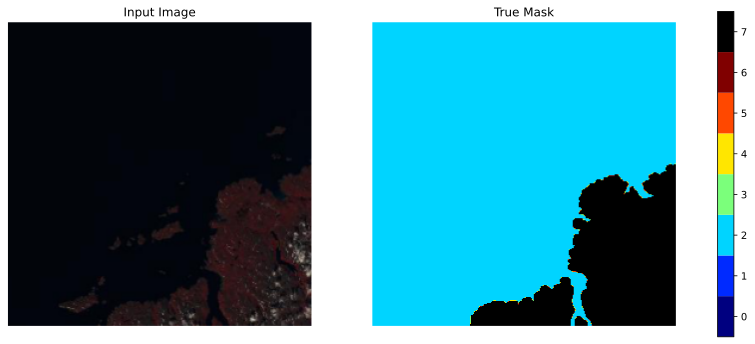

In [267]:
%matplotlib inline
def display(display_list):
    fig, axs = plt.subplots(nrows=1, ncols = len(display_list), figsize=(15, 6))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        axs[i].set_title(title[i])
        if i==0:
            pilimage = torchvision.transforms.ToPILImage()(display_list[i])
            axs[i].imshow(np.asarray(pilimage))
        else:
            # msk = axs[i].imshow(np.squeeze(display_list[i]), cmap = cmap, vmin=0, vmax=n_colors-1)
            mask = torchvision.transforms.ToPILImage()(display_list[i])
            mask = axs[i].imshow(np.asarray(mask), cmap = cmap, vmin=0, vmax=n_colors-1)
        axs[i].axis('off')
        
    #plot colorbar
    cbar = fig.colorbar(mask, ax=axs, location='right')
    tick_locs = (np.arange(n_colors) + 0.5)*(n_colors-1)/n_colors#new tick locations so they are in the middle of the colorbar
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_colors))
    plt.show()

for i, data in enumerate(ds_train, 0):
    print(i)
    sample_image, sample_mask = data
    break
display([sample_image[0], sample_mask[0]])

# Define Model

This model is an adapted version U-NET from the Dstl Satellite Imagery Feature Detection Kaggle competition. That competition also aimed to classify pixels in satelite images, so this model architucture might be a good fit here too. https://www.kaggle.com/drn01z3/end-to-end-baseline-with-u-net-keras

In [268]:
from torch import nn
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # store the convolution and ReLU layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size=3,padding=1)

    def forward(self,x):
        # apply the block to the input x
        return self.conv2(self.relu(self.conv1(x)))

class Encoder(nn.Module):
    def __init__(self, channels=(3,16,32,64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = nn.ModuleList([ Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the iputs through the current encoder block, store the inputs, and then apply maxpooling on the output
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            x = self.dropout(x)

        # return the list containing the intermediate outputs
        return blockOutputs

class Decoder(nn.Module):
    def __init__(self, channels=(64,32,16)):
        super().__init__()
        # initialize the number of channels, upsampler blocks, and decoder blocks
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(channels[i],channels[i+1],2,2) for i in range(len(channels)-1)])
        self.dec_blocks = nn.ModuleList([Block(channels[i],channels[i+1]) for i in range(len(channels)-1)])

    def forward(self,x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels)-1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)

            # crop the current features from the encoder blocks, 
            # concatenate them with the current upsampled features,
            # pass the concatenated output through the current decoder block
            encFeat = self.crop(encFeatures[i],x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)

        return x

    def crop(self, encFeatures, x):
        # grab the dimensions of the inputs, ad crop the encoder features to match the dimesion
        (_, _, H, W) = x.shape
        encFeatures = torchvision.transforms.CenterCrop([H,W])(encFeatures)
        return encFeatures

class UNet(nn.Module):
    def __init__(self, encChannels=(3,16,32,64), decChannels=(64,32,16),
    nbClasses=1,retainDim=True,outSize=IMG_SIZE):
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        # initialize the regression head and store the class variables
        self.head = nn.Conv2d(decChannels[-1],nbClasses,1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self,x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        # pass the encoder features through decoder making sure that their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])

        # pass the decoder features through the regression head to obtain the segmentation mask
        map = self.head(decFeatures)

        # check to see if we retain the original output dimensions and resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
        
        # return the segmentation map
        return map

# Train Model

In [269]:
# #function to generate a mask from the model predictions
# def create_mask(pred_mask, ele=0):
#     pred_mask = tf.argmax(pred_mask, axis=-1)#use the highest probability class as the prediction
#     pred_mask = pred_mask[..., tf.newaxis]
#     return pred_mask[ele]

# #helper functions to plot image, mask, and predicted mask while training
# def show_predictions(dataset=None, num=1, ele=0):
#     if dataset:
#         for image, mask in dataset.take(num):
#             pred_mask = model.predict(image)
#             display([image[ele], mask[ele], create_mask(pred_mask, ele)])
#     else:
#         display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# #function to display loss during training
# def plot_loss_acc(loss, val_loss, epoch):#, acc, val_acc, epoch):
    
#     epochs = range(epoch+1)
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

#     ax.plot(epochs, loss, 'r', label='Training loss')
#     ax.plot(epochs, val_loss, 'bo', label='Validation loss')
#     ax.set_title('Training and Validation Loss')
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Loss Value')
#     ax.legend()
#     plt.show()
    
# #callback to clear output and show predictions
# from IPython.display import clear_output

# class DisplayCallback(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs=None):
#         self.loss = []
#         self.val_loss = []
    
#     def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        
#         self.loss.append(logs['loss'])
#         self.val_loss.append(logs['val_loss'])
        
#         show_predictions()
#         plot_loss_acc(self.loss, self.val_loss, epoch)
        
# #callback to reduce learning rate when loss plateaus
# lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=8, verbose=1,)

# #Define IoU metric (by stack overflow user HuckleberryFinn)
# class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
#     def __init__(self,
#                y_true=None,
#                y_pred=None,
#                num_classes=None,
#                name=None,
#                dtype=None):
#         super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred = tf.math.argmax(y_pred, axis=-1)
#         return super().update_state(y_true, y_pred, sample_weight)

# # Create a callback that saves the model's weights
# checkpoint_path = "training/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*BATCH_SIZE)

In [270]:
# import the necessary packages
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [271]:
model = UNet()
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()  #nn.CrossEntropyLoss
opt = Adam(model.parameters(),lr = 1.e-4)

# calculate steps per epoch for trainning and test datasets
trainSteps = len(ds_train) // BATCH_SIZE
testSteps  = len(ds_val) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train loss": [], "test_loss": []}

# loop over epochs
print('[INFO] training the network...')
startTime = time.time()
NUM_EPOCHS = 100
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    model.train()

    # initialize the total trainig and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0

    # loop over the training set
    for (i, (x,y)) in enumerate(ds_train):
        # send the input to the device
        # (x,y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)

        # first, zero out any previously accumulated gradients, then perform backpropagation, ad then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss 
        totalTrainLoss += loss
        print(f'totalTrainLoss: {totalTrainLoss}, loss: {loss}')
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x,y) in ds_val:
            # send the input to the device
            # (x,y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            loss = lossFunc(pred, y)
            totalTestLoss += loss

    # calculate the average train and validiation losses
    avgTrainLoss = totalTrainLoss/trainSteps
    avgTestLoss  = totalTestLoss/testSteps
	# update our training history
    
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))

# display the total time cost for training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# #train model
# model=get_unet()
# model.compile(optimizer=tf.keras.optimizers.Adam(), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
#               metrics=['sparse_categorical_accuracy', UpdatedMeanIoU(num_classes=n_colors)])

# EPOCHS = 100
# VAL_SUBSPLITS = 5
# VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

# model_history = model.fit(train_dataset, 
#                           epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           validation_data=val_dataset,
#                           callbacks=[DisplayCallback(), lr_callback, cp_callback])

[INFO] training the network...


  0%|          | 0/100 [00:00<?, ?it/s]

totalTrainLoss: 0.6798797249794006, loss: 0.6798797249794006
totalTrainLoss: 1.3590095043182373, loss: 0.6791297197341919
totalTrainLoss: 2.0364389419555664, loss: 0.6774293184280396
totalTrainLoss: 2.7123634815216064, loss: 0.6759245991706848
totalTrainLoss: 3.3903543949127197, loss: 0.6779908537864685
totalTrainLoss: 4.065059661865234, loss: 0.6747050881385803
totalTrainLoss: 4.740234375, loss: 0.6751748323440552
totalTrainLoss: 5.412649631500244, loss: 0.6724152565002441
totalTrainLoss: 6.088051795959473, loss: 0.6754021644592285
totalTrainLoss: 6.762728214263916, loss: 0.6746764779090881
totalTrainLoss: 7.43693208694458, loss: 0.6742039322853088
totalTrainLoss: 8.1069917678833, loss: 0.6700597405433655
totalTrainLoss: 8.779467582702637, loss: 0.6724753975868225
totalTrainLoss: 9.44534969329834, loss: 0.6658816933631897
totalTrainLoss: 10.115285873413086, loss: 0.6699361801147461
totalTrainLoss: 10.783143043518066, loss: 0.6678575277328491
totalTrainLoss: 11.447900772094727, loss: 0

  0%|          | 0/100 [11:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from d2l import torch as d2l
model = UNet()
num_epochs = 100
lr = 1.e-4
loss = nn.CrossEntropyLoss(reduction='none')

for i, (X,y) in enumerate(ds_train):
    break
# X.size()
device = d2l.try_gpu()
# X, y = X.to(device), y.to(device)
# print(type(X))
# encChannels=(3,16,32,64)
# block = nn.ModuleList([ Block(encChannels[0],encChannels[1])])
# x = block(X)
# encFeatures = Encoder(encChannels)(X)
# print(encoder(X))
# (X)
# y_hat = model(X)
d2l.train_ch6(model, ds_train, ds_val, num_epochs, lr, device)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

ax[0].plot(epochs, loss, 'r', label='Training')
ax[0].plot(epochs, val_loss, 'bo', label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss Value')
ax[0].legend()

IoU_key = list(model_history.history.keys())[2]
acc = model_history.history[IoU_key]
val_acc = model_history.history['val_'+IoU_key]

ax[1].plot(epochs, acc, 'r', label='Training')
ax[1].plot(epochs, val_acc, 'bo', label='Validation')
ax[1].set_title('Training and Validation IoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU Value')
ax[1].legend()
plt.show()

In [ ]:
#load weights for checkpoint 51
# print(os.listdir(checkpoint_dir))
model.load_weights(checkpoint_dir + '/cp-0051.ckpt')
scores = model.evaluate(val_dataset, verbose=0)
print('Final Model Validation Scores')
print('Loss: {:.3f}'.format(scores[0]))
print('Accuracy: {:.3f}'.format(scores[1]))
print('IoU: {:.3f}'.format(scores[2]))

In [ ]:
show_predictions(val_dataset, num=10, ele=3)

In [ ]:
#plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_cm(model, val_ds):
    cm = np.zeros((8,8))
    for img_batch, mask_batch in val_dataset:
        y_pred = []
        y_true = []
        pred_batch = model.predict(img_batch)
        pred_batch = tf.argmax(pred_batch, axis=-1)#take the highest probability as the prediction for each pixel
        for n, pred in enumerate(pred_batch):
            pred = np.array(pred).flatten() #flattened array of predicted pixels for each image
            mask = np.array(mask_batch[n, ...]).flatten() #flattened array of mask pixels for the image
            y_pred.extend(pred)
            y_true.extend(mask)
        cm = cm + confusion_matrix(y_true, y_pred)
    return cm

cm = get_cm(model, val_dataset)
plt.figure(figsize=(12,8))
sns.heatmap(cm.astype(int), annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# import torchvision
# import torchvision.transforms as transforms
# #function to read image and mask from file
# def read_image(image_name):
#     #Reads a JPEG or PNG image into a 3 dimensional RGB or grayscale Tensor. 
#     # image = torchvision.io.read_image(img_dir + image_name + img_ext,mode=torchvision.io.image.ImageReadMode.GRAY)
#     image = Image.open(img_dir + image_name + img_ext)
#     train_augs = transforms.Compose([transforms.ToTensor(), 
#                                 transforms.Resize(IMG_SIZE), 
#                                 transforms.Grayscale(3)])
#     image = train_augs(image)
    
#     mask = Image.open(mask_dir + image_name + mask_ext)
#     mask = transforms.ToTensor()(mask)
#     mask = transforms.Resize(IMG_SIZE)(mask)
#     return image, mask


# #image augmentation function to randomly flip and rotate each image and corresponding mask
# def augment_image(image, mask):
#     trans = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.RandomVerticalFlip(p=0.5),
#                                 ])    
#     image = trans(image)
#     mask  = trans(mask)
    
#     #rotate image randomly in the range of +-5 degrees
#     image = transforms.RandomRotation(degrees=5,center=True,fill=0)(image)
#     #add black to rotated corners,make this black space correspond to land
#     mask  = transforms.RandomRotation(degrees=5,center=True,fill=7)(image)
#     return image, mask

